In [3]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent


# Male Only

In [4]:
dataset_name = 'male_only'

## GRT123

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv
Total number of included nodule annotations: 861
Total number of nodule annotations: 861
Cases: 600


100%|██████████| 1000/1000 [00:27<00:00, 36.53it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.14,0.11,0.16
159,0.25,0.20,0.16,0.23
476,0.50,0.32,0.28,0.37
1111,1.00,0.46,0.41,0.50
2381,2.00,0.59,0.54,0.64
4920,4.00,0.72,0.68,0.76
9999,8.00,0.80,0.77,0.83


Mean Sensitivity: 0.46 Low Sensitivity: 0.42 High Sensitivity: 0.5


,True positives,753
0,False positives,15764.000
1,False negatives,108.000
2,True negatives,0.000
3,Total number of candidates,16532.000
4,Total number of nodules,861.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,15.000
7,Sensitivity,0.875
8,Average number of candidates per scan,27.553


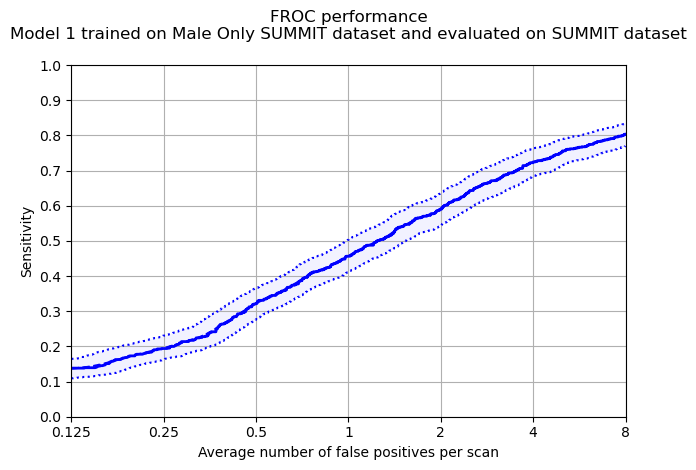

In [5]:
# Add in diameter cuts for later analysis
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv')
annotations['diameter_cats'] = pd.cut(
    annotations['diameter_mm'],
    bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 999],
    labels=['1. 0-5', '2. 5-10', '3. 10-15', '4. 15-20', '5. 20-25', '6. 25-30', '7. 30-35', '8. 35-40', '9. 40+']
)

# save back to the metadata file
annotations.to_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv', index=False)
grt123_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/male_only/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_predictions.csv",    
    filter='\nModel 1 trained on Male Only SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/male_only',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/male_only/froc_male_only_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/male_only/CADAnalysis.txt')

### Gender analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpd2ft7isy/annotations.csv
Total number of included nodule annotations: 861
Total number of nodule annotations: 861
Cases: 600


100%|██████████| 1000/1000 [00:31<00:00, 31.84it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.14,0.11,0.17
159,0.25,0.20,0.16,0.23
476,0.50,0.32,0.28,0.37
1111,1.00,0.46,0.41,0.50
2381,2.00,0.59,0.55,0.64
4920,4.00,0.72,0.68,0.77
9999,8.00,0.80,0.77,0.84


Mean Sensitivity: 0.46 Low Sensitivity: 0.42 High Sensitivity: 0.5


,True positives,753
0,False positives,15764.000
1,False negatives,108.000
2,True negatives,0.000
3,Total number of candidates,16532.000
4,Total number of nodules,861.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,15.000
7,Sensitivity,0.875
8,Average number of candidates per scan,27.553


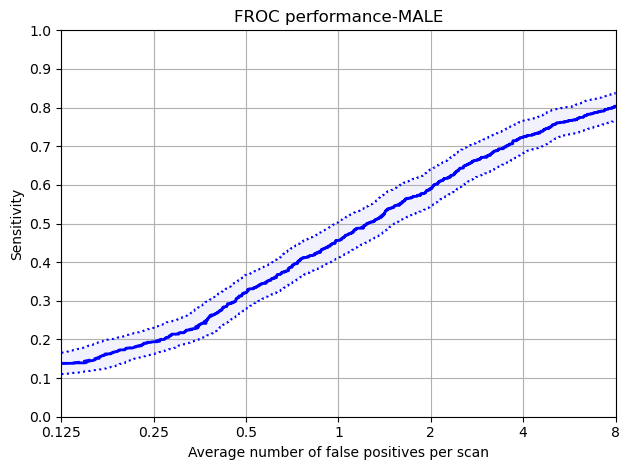

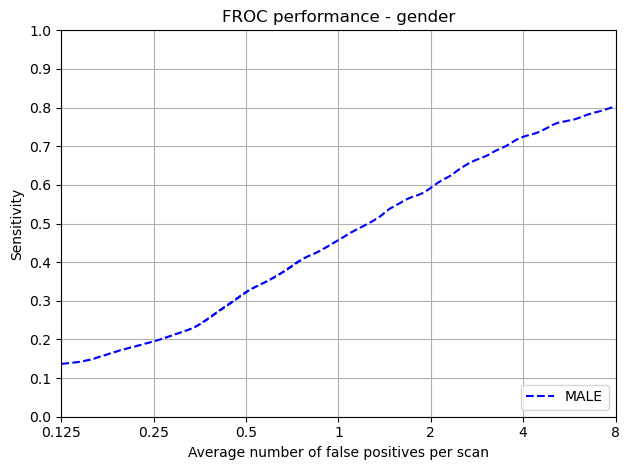

In [6]:
def set_is_actionable(row):
    if row['radiology_report_management_plan_final'] in ['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1']:
        return 'Actonable'
    else:
        return 'Non-Actionable'

scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/male_only/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .assign(is_actionable=lambda df: df.apply(set_is_actionable, axis=1))
    .assign(gender_by_actionable=lambda df: df.apply(set_gender_by_actionable, axis=1))    
    .assign(ethnic_group_by_actionable=lambda df: df.apply(set_ethnic_group_by_actionable, axis=1))    
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
)

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/male_only/{protected_group}'
)

### Ethnicity analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpq9j25g7u/annotations.csv
Total number of included nodule annotations: 782
Total number of nodule annotations: 782
Cases: 518


100%|██████████| 1000/1000 [00:22<00:00, 44.29it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.13,0.10,0.17
159,0.25,0.19,0.15,0.23
476,0.50,0.31,0.27,0.36
1111,1.00,0.45,0.40,0.50
2381,2.00,0.58,0.53,0.62
4920,4.00,0.71,0.66,0.75
9999,8.00,0.79,0.76,0.83


Mean Sensitivity: 0.45 Low Sensitivity: 0.41 High Sensitivity: 0.49


,True positives,684
0,False positives,14031.000
1,False negatives,98.000
2,True negatives,0.000
3,Total number of candidates,14730.000
4,Total number of nodules,782.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,15.000
7,Sensitivity,0.875
8,Average number of candidates per scan,28.436


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp3uqoy85p/annotations.csv
Total number of included nodule annotations: 26
Total number of nodule annotations: 26
Cases: 37


100%|██████████| 1000/1000 [00:01<00:00, 757.36it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.18,0.00,0.40
159,0.25,0.27,0.11,0.54
476,0.50,0.45,0.23,0.69
1111,1.00,0.56,0.38,0.76
2381,2.00,0.65,0.48,0.80
4920,4.00,0.69,0.50,0.83
9999,8.00,0.75,0.58,0.88


Mean Sensitivity: 0.51 Low Sensitivity: 0.33 High Sensitivity: 0.7


,True positives,20
0,False positives,650.000
1,False negatives,6.000
2,True negatives,0.000
3,Total number of candidates,670.000
4,Total number of nodules,26.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,0.000
7,Sensitivity,0.769
8,Average number of candidates per scan,18.108


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpyc0uevz9/annotations.csv
Total number of included nodule annotations: 22
Total number of nodule annotations: 22
Cases: 19


100%|██████████| 1000/1000 [00:01<00:00, 909.19it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.21,0.00,0.54
159,0.25,0.27,0.00,0.57
476,0.50,0.43,0.08,0.72
1111,1.00,0.66,0.36,0.86
2381,2.00,0.78,0.63,1.00
4920,4.00,0.89,0.74,1.00
9999,8.00,0.89,0.74,1.00


Mean Sensitivity: 0.59 Low Sensitivity: 0.36 High Sensitivity: 0.81


,True positives,19
0,False positives,450.000
1,False negatives,3.000
2,True negatives,0.000
3,Total number of candidates,469.000
4,Total number of nodules,22.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,0.000
7,Sensitivity,0.864
8,Average number of candidates per scan,24.684


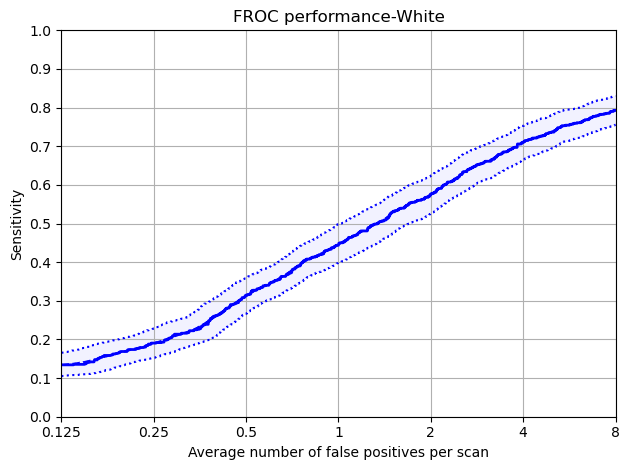

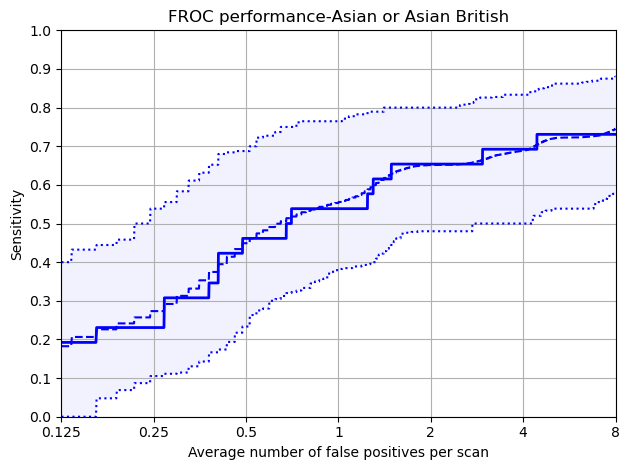

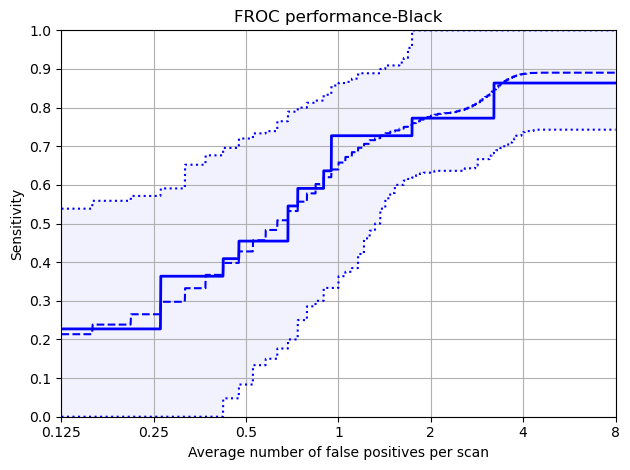

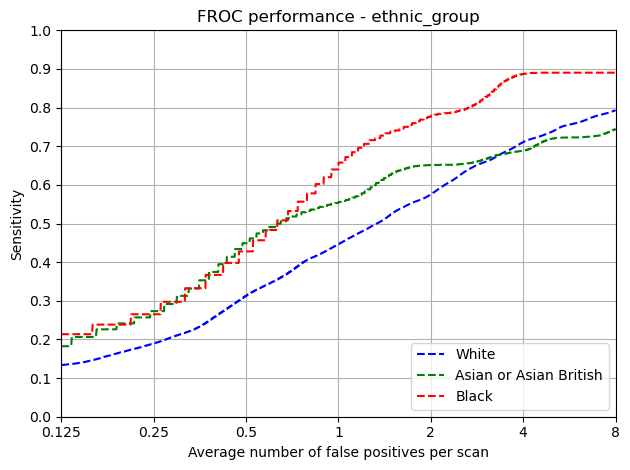

In [10]:
def protected_group_analysis2(protected_group, scan_metadata, annotations, exclusions, predictions, output_path):

    output_path = Path(output_path)

    analysis_dict = {}

    for cat in scan_metadata[protected_group].unique():

        if not cat in ['White', 'Asian or Asian British', 'Black']:
            continue

        with TemporaryDirectory() as temp_dir:
            temp_dir = Path(temp_dir)
            temp_scans = scan_metadata[scan_metadata[protected_group] == cat]['name']
            temp_annotations = annotations[annotations['name'].isin(temp_scans.values)]
            temp_exclusions = exclusions[exclusions['name'].isin(temp_scans.values)]
            temp_predictions = predictions[predictions['name'].isin(temp_scans.values)]

            temp_scans.to_csv(temp_dir / 'scans.csv', index=False)
            temp_annotations.to_csv(temp_dir / 'annotations.csv', index=False)
            temp_exclusions.to_csv(temp_dir / 'exclusions.csv', index=False)
            temp_predictions.to_csv(temp_dir / 'predictions.csv', index=False)

            result = noduleCADEvaluation(
                annotations_filename=temp_dir / 'annotations.csv',
                annotations_excluded_filename=temp_dir / 'exclusions.csv',
                seriesuids_filename=temp_dir / 'scans.csv',
                results_filename=temp_dir / 'predictions.csv',
                filter=f'-{cat}',
                outputDir=output_path / cat,
            )

            caluclate_cpm_from_bootstrapping(output_path / cat / 'froc_predictions_bootstrapping.csv')
            show_metrics(output_path / cat / 'CADAnalysis.txt')

            analysis_dict[cat] = (
                pd.read_csv(output_path / cat / 'froc_predictions_bootstrapping.csv')
                .rename(columns={
                    'FPrate': 'FPRate',
                    'Sensivity[Mean]': 'Sensitivity',
                    'Sensivity[Lower bound]': 'LowSensitivity',
                    'Sensivity[Upper bound]': 'HighSensitivity'
                })
            )

    fig1 = plt.figure()
    ax = plt.gca()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for idx, cat in enumerate(analysis_dict.keys()):

        metrics = analysis_dict[cat]        
        plt.plot(metrics['FPRate'], metrics['Sensitivity'], ls='--', color=colors[idx],label=cat)
        # plt.plot(metrics['FPRate'], metrics['LowSensitivity'], ls=':', color=colors[idx])
        # plt.plot(metrics['FPRate'], metrics['HighSensitivity'], ls=':', color=colors[idx])
        # ax.fill_between(metrics['FPRate'], metrics['LowSensitivity'], metrics['HighSensitivity'], alpha=0.05)

    xmin = 0.125
    xmax = 8
    plt.xlim(xmin, xmax)
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    #plt.legend(loc='lower right')
    plt.title(f'FROC performance - {protected_group}')
    plt.xscale('log', base=2)
    ax.xaxis.set_major_formatter(FixedFormatter([0.125,0.25,0.5,1,2,4,8]))

    # set your ticks manually
    ax.xaxis.set_ticks([0.125,0.25,0.5,1,2,4,8])
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    plt.legend(loc='lower right')
    plt.grid(visible=True, which='both')
    plt.tight_layout()


protected_group = 'ethnic_group'
data_dict = protected_group_analysis2(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/male_only/{protected_group}'
)

### Is Actionable

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpc68gaovw/annotations.csv
Total number of included nodule annotations: 525
Total number of nodule annotations: 525
Cases: 194


100%|██████████| 1000/1000 [00:08<00:00, 117.38it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.11,0.20
159,0.25,0.19,0.15,0.24
476,0.50,0.28,0.22,0.34
1111,1.00,0.40,0.35,0.46
2381,2.00,0.54,0.48,0.59
4920,4.00,0.65,0.59,0.71
9999,8.00,0.75,0.71,0.80


Mean Sensitivity: 0.42 Low Sensitivity: 0.37 High Sensitivity: 0.48


,True positives,450
0,False positives,5575.000
1,False negatives,75.000
2,True negatives,0.000
3,Total number of candidates,6040.000
4,Total number of nodules,525.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,15.000
7,Sensitivity,0.857
8,Average number of candidates per scan,31.134


/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpebwtttsm/annotations.csv
Total number of included nodule annotations: 336
Total number of nodule annotations: 336
Cases: 407


100%|██████████| 1000/1000 [00:15<00:00, 64.26it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.10,0.07,0.15
159,0.25,0.19,0.14,0.24
476,0.50,0.36,0.30,0.42
1111,1.00,0.53,0.47,0.59
2381,2.00,0.67,0.62,0.73
4920,4.00,0.80,0.75,0.85
9999,8.00,0.86,0.82,0.90


Mean Sensitivity: 0.5 Low Sensitivity: 0.45 High Sensitivity: 0.55


,True positives,303
0,False positives,10189.000
1,False negatives,33.000
2,True negatives,0.000
3,Total number of candidates,10492.000
4,Total number of nodules,336.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,0.000
7,Sensitivity,0.902
8,Average number of candidates per scan,25.779


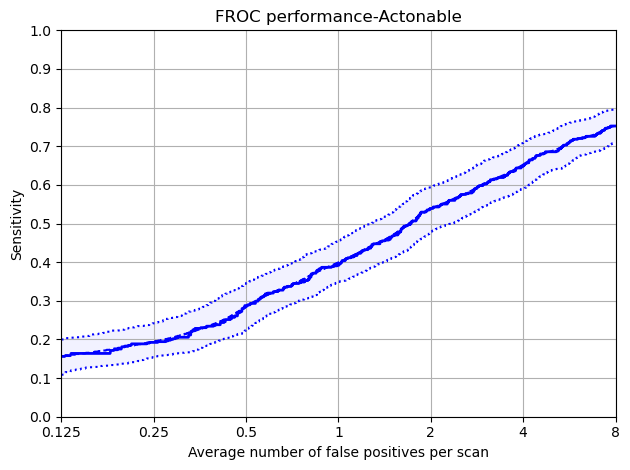

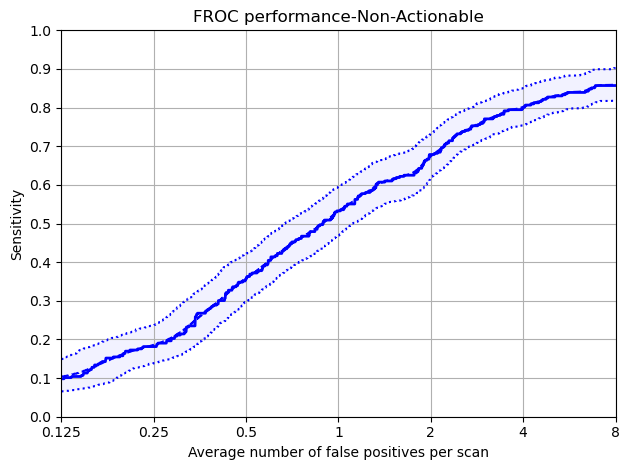

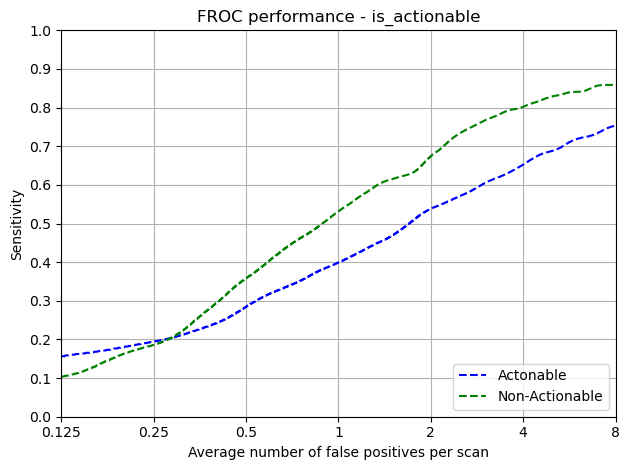

In [8]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/male_only/{protected_group}'
)

In [9]:
protected_group = 'gender_by_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/male_only/{protected_group}'
)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpm13wbdtk/annotations.csv
Total number of included nodule annotations: 525
Total number of nodule annotations: 525
Cases: 194


 31%|███       | 311/1000 [00:02<00:05, 122.11it/s]


KeyboardInterrupt: 

In [ ]:
protected_group = 'ethnic_group_by_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/male_only/{protected_group}'
)

### False positive and Miss Investigations

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)
missed_metadata = miss_anaysis_at_fpps(
    scans_path=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    annotations_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    predictions_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_predictions.csv',
    thresholds=thresholds
)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for ivx, var in enumerate(['nodule_type','management_plan','diameter_cats']):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv')
    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []
    for idx, metadata in enumerate(missed_metadata):
        vc = metadata[var].value_counts().sort_index()

        results.append((total_vc - vc).rename(f'{operating_points[idx]} FPPs'))

    df = pd.concat(results, axis=1).fillna(0).round(2)

    for column in df.T:
        ax[ivx].plot(df.T[column], label=column)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('Number of Annotations')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Misses at Different FPPs')
plt.show()

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)

scans = pd.read_csv(f'{workspace_path}/metadata/summit/male_only/test_scans.csv')
predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_predictions.csv')
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/male_only/male_only_metadata.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

In [ ]:
cnt = 0

df = false_positives_fpps['0.125']

for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    study_id = row['name']
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(study_id)
    show_numpy_candidate_location(study_id, x, y, z, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break

## MONAI Detection

In [ ]:

detection_predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit/summit/male_only', 'test')
detection_predictions = pd.read_csv(detection_predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/male_only/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
    .assign(diameter_cats=lambda df: pd.cut(
        df['nodule_diameter_mm'],
        bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 999],
        labels=['1. 0-5', '2. 5-10', '3. 10-15', '4. 15-20', '5. 20-25', '6. 25-30', '7. 30-35', '8. 35-40', '9. 40+']
    ))
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/male_only/test_scans.csv',
    results_filename=detection_predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/summit/male_only',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/summit/male_only/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/summit/male_only/CADAnalysis.txt')


### Gender analysis

In [ ]:


annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv')

predictions = pd.read_csv(detection_predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/male_only/{protected_group}'
)

### Ethnicity Analysis

In [ ]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/male_only/{protected_group}'
)

### Is Actionable

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/male_only/{protected_group}'
)

In [ ]:
protected_group = 'gender_by_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/male_only/{protected_group}'
)


In [ ]:
protected_group = 'ethnic_group_by_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/male_only/{protected_group}'
)



### False Positive and Miss Analysis


In [ ]:
thresholds = get_thresholds(detection_summit_summit)
print(thresholds)
missed_metadata = miss_anaysis_at_fpps(
    scans_path=f'{workspace_path}/metadata/summit/male_only/test_scans.csv',
    annotations_path=f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    predictions_path=detection_predictions_path,
    thresholds=thresholds
)

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for ivx, var in enumerate(['nodule_type','management_plan','diameter_cats']):
    annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv')
    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []
    for idx, metadata in enumerate(missed_metadata):
        vc = metadata[var].value_counts().sort_index()

        results.append((total_vc - vc).rename(f'{operating_points[idx]} FPPs'))

    df = pd.concat(results, axis=1).fillna(0).round(2)

    for column in df.T:
        ax[ivx].plot(df.T[column], label=column)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('Number of Annotations')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Misses at Different FPPs')
plt.show()

In [ ]:
# Check what nodules have been missed by gender


missed_metadata_at_2fpps = missed_metadata[4]

def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

_ = crosstab_with_percentages(
    [missed_metadata_at_2fpps['nodule_type'], missed_metadata_at_2fpps['management_plan']],
    [missed_metadata_at_2fpps['gender']],
    table=True,
    heatmap=True)

In [ ]:
scans = pd.read_csv(f'{workspace_path}/metadata/summit/male_only/test_scans.csv')
predictions = pd.read_csv(detection_predictions_path)
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/male_only/annotations.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

In [ ]:
df = false_positives_fpps['0.125']

cnt = 0
for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    scan_id = row['name']
    study_id = scan_id.split('_')[0]
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(scan_id)
    scan = SummitScan.load_scan(f'{workspace_path}/data/summit/scans/{study_id}/{scan_id}.mhd')

    irc = xyz2irc([x, y, z], scan.origin, scan.voxel_size, scan.orientation)


    show_mhd_candidate_location(scan.image, irc.row, irc.col, irc.index, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break